Load data

In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

path_train = './data-z3/train/'
path_test = './data-z3/test/'
path_valid = './data-z3/valid/'

Generate Images

In [73]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32

image_generator = ImageDataGenerator(
    rescale = 1./255.,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator = image_generator.flow_from_directory(
    directory = path_train,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
)

valid_generator = image_generator.flow_from_directory(
    directory = path_valid,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
)

test_generator = tf.keras.preprocessing.image_dataset_from_directory(
    directory = path_test,
    image_size = IMG_SIZE,
    batch_size = 1,
    shuffle = False,
)

Found 13572 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 files belonging to 100 classes.


Plot images

In [81]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = path_train,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False,
)

classes = train_generator.class_indices
inv_map = {v: k for k, v in classes.items()}

dataset_unbatched = tuple(dataset.unbatch())
labels = []
images = []
for (image, label) in dataset_unbatched:
    labels.append(label.numpy())
    images.append(image.numpy())
labels = pd.Series(labels)
count = labels.value_counts()

res = []
for i in range(0, len(count)):
    res.append([inv_map[i], count[i]])

Found 13572 files belonging to 100 classes.


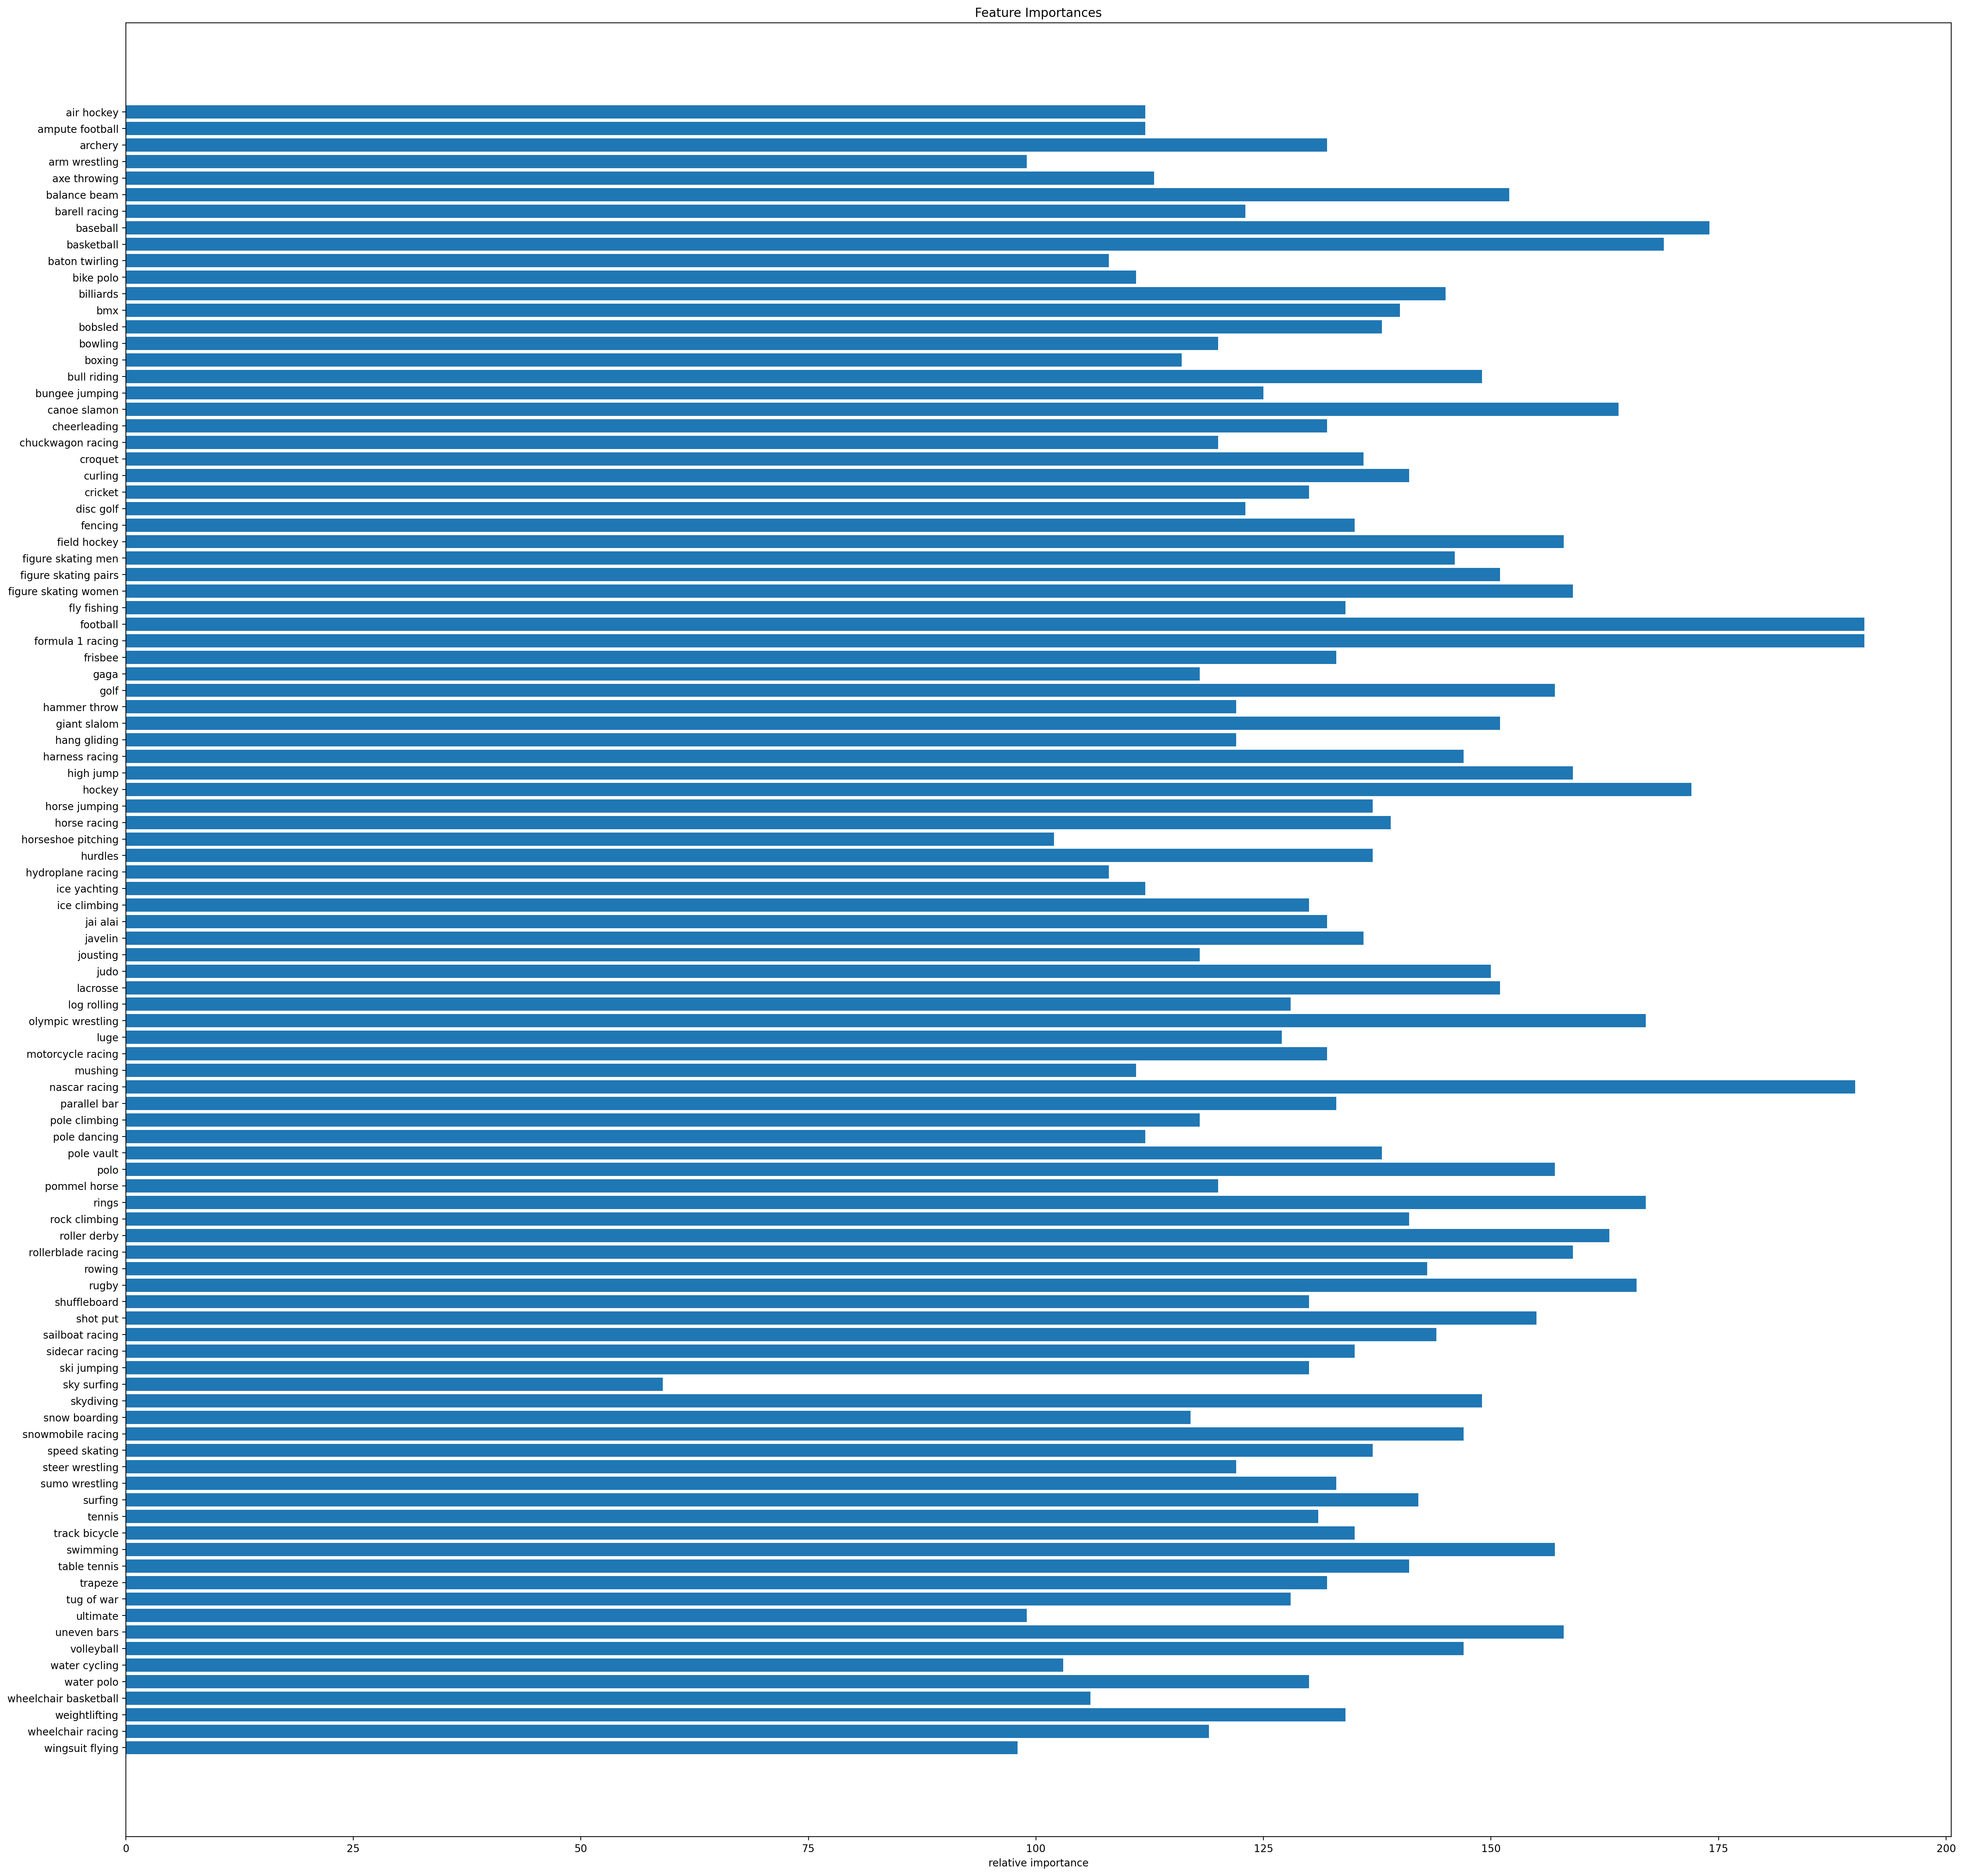

In [82]:
from matplotlib.pyplot import figure

def plot_importances(count):
    figure(figsize = (32, 32), dpi = 200)

    features = [i[0] for i in res]
    importances = count
    indices = np.argsort(importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], align = 'center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('relative importance')
    plt.show()

plot_importances(count)

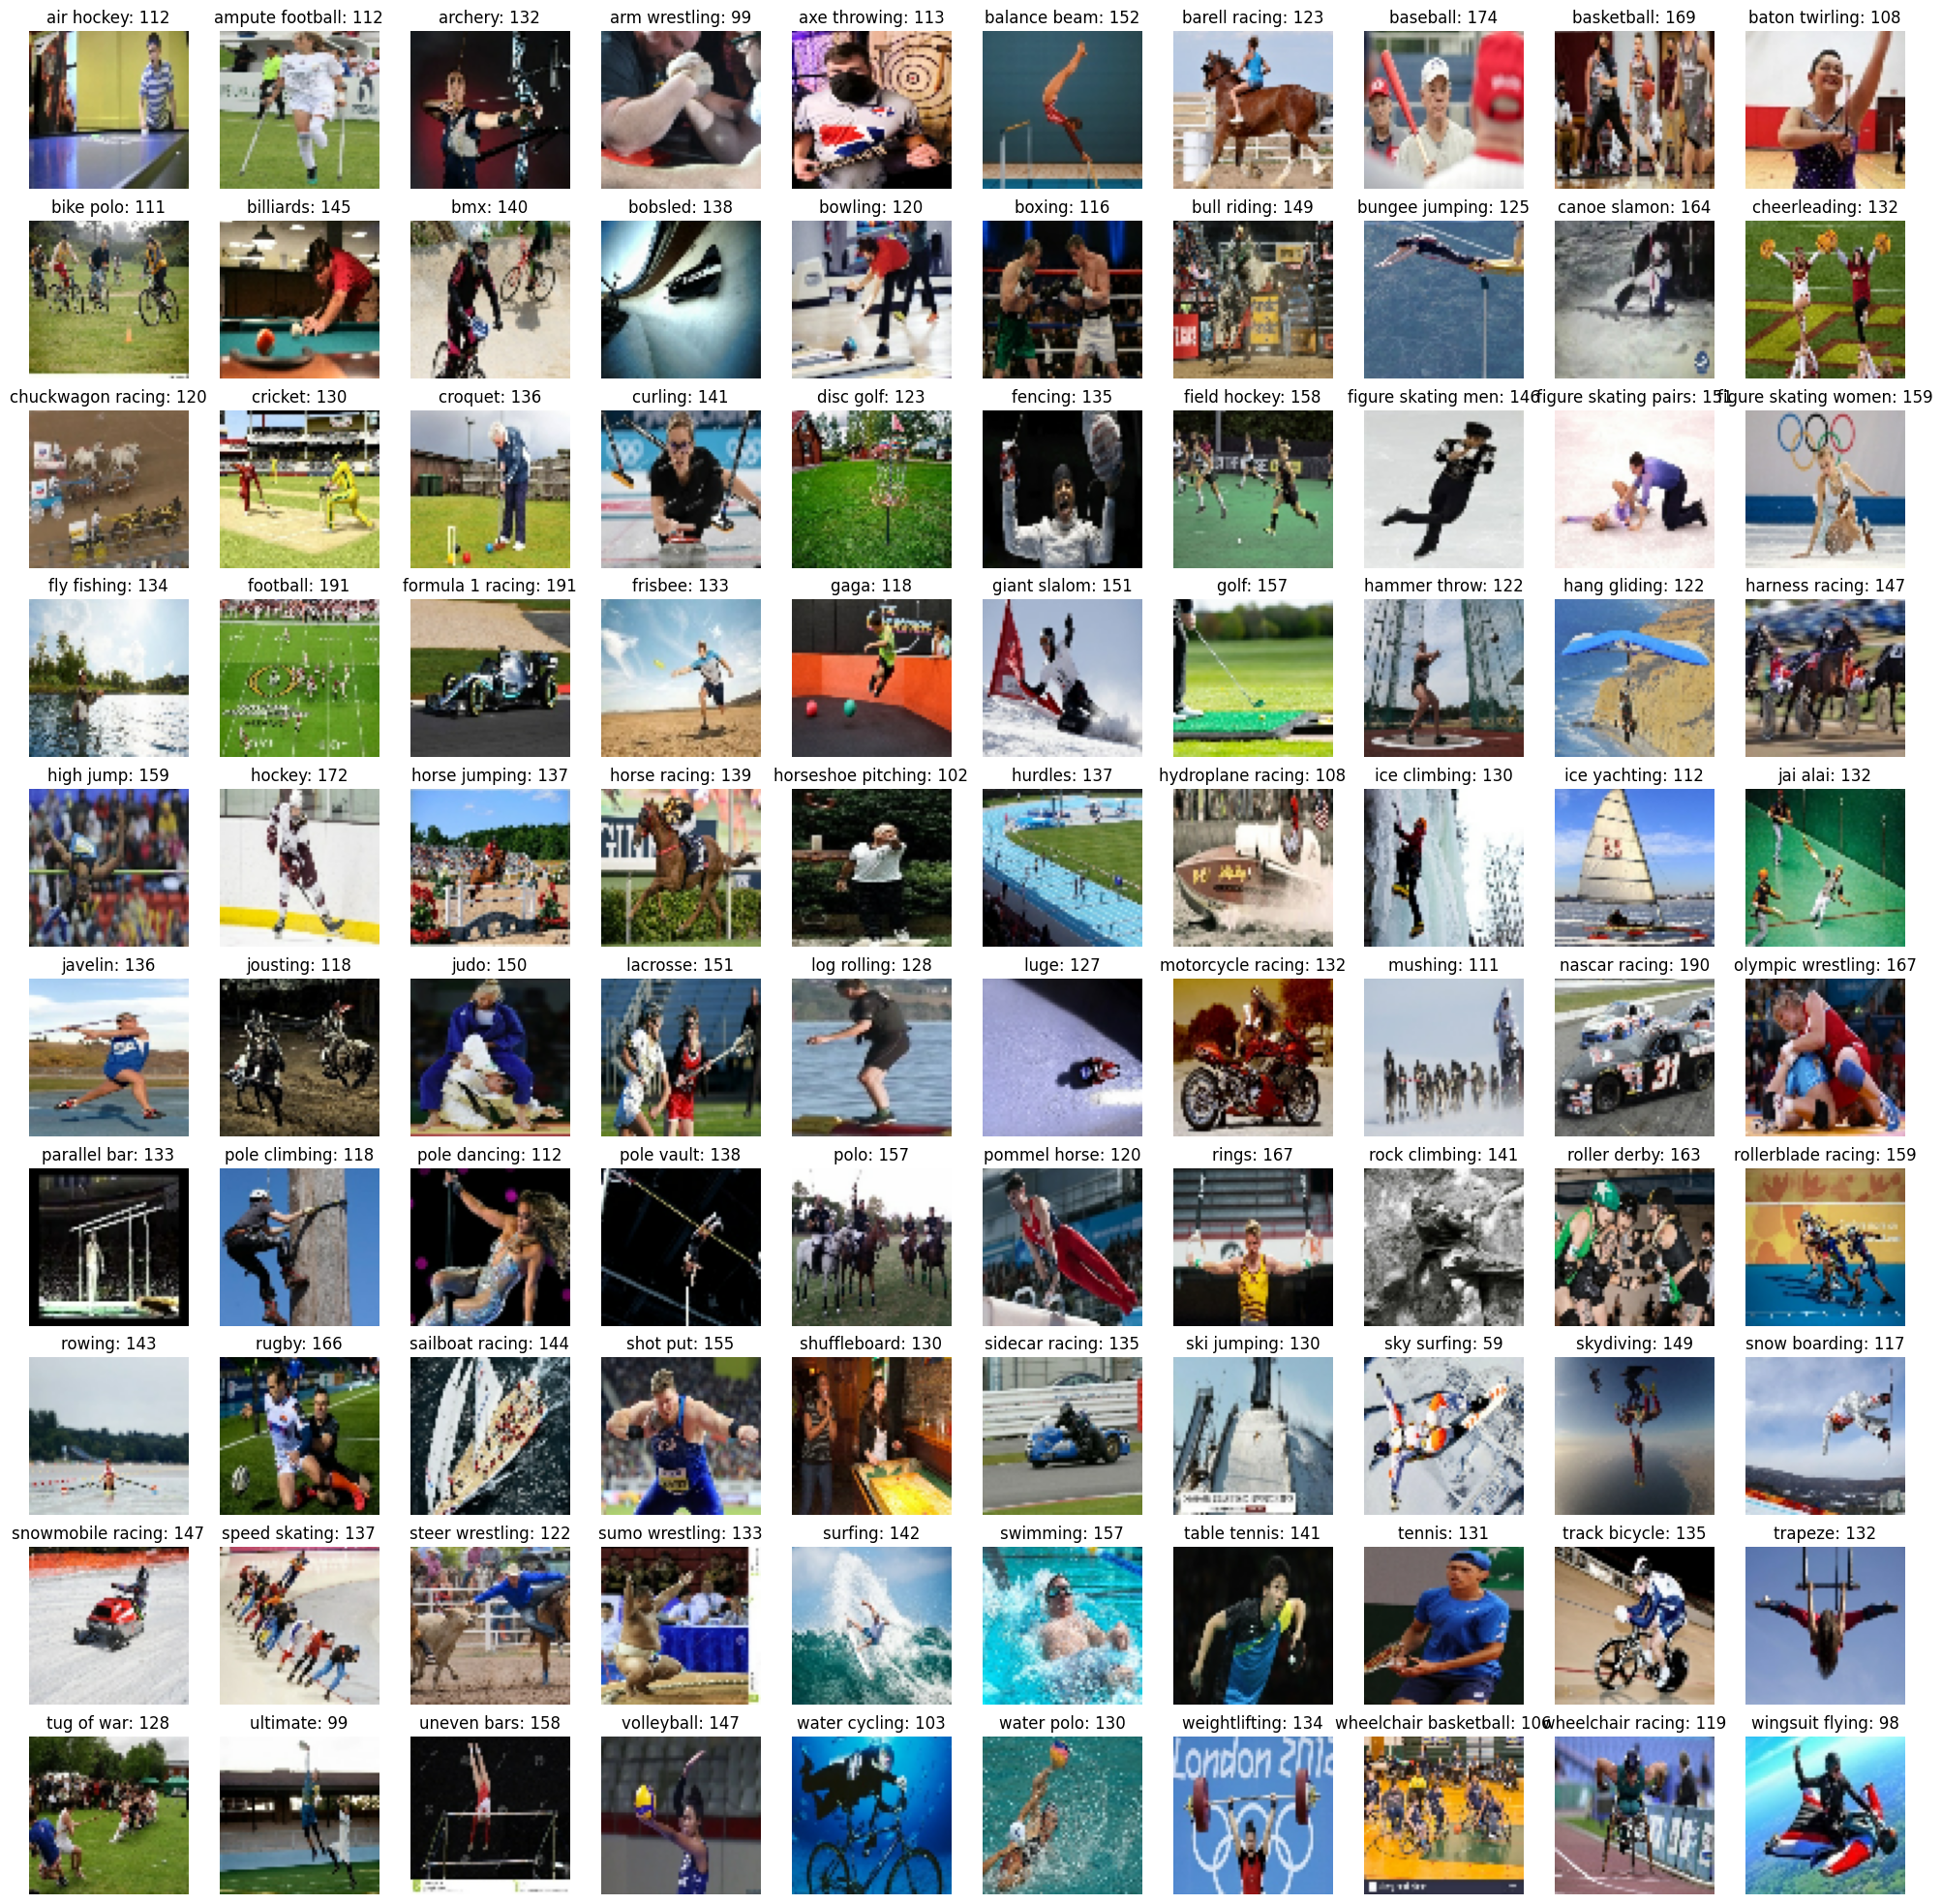

In [83]:
c = 0

plt.figure(figsize = (25, 25))
for i in range(100):
    image = images[c]
    c += count[i]
    
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(image.astype("uint8"), aspect = "auto")
    plt.title(inv_map[i] + ": " + str(count[i]))
    plt.axis("off")

EDA 2

In [84]:
import os
filenames = []
imgs = []

for filename in os.listdir(path_train):
    filenames.append(filename)

filenames = sorted(filenames)

for i in filenames:
    filename = os.listdir(path_train + i)[0]
    imgs.append(path_train + i + '/' + filename)

Plot EDA2

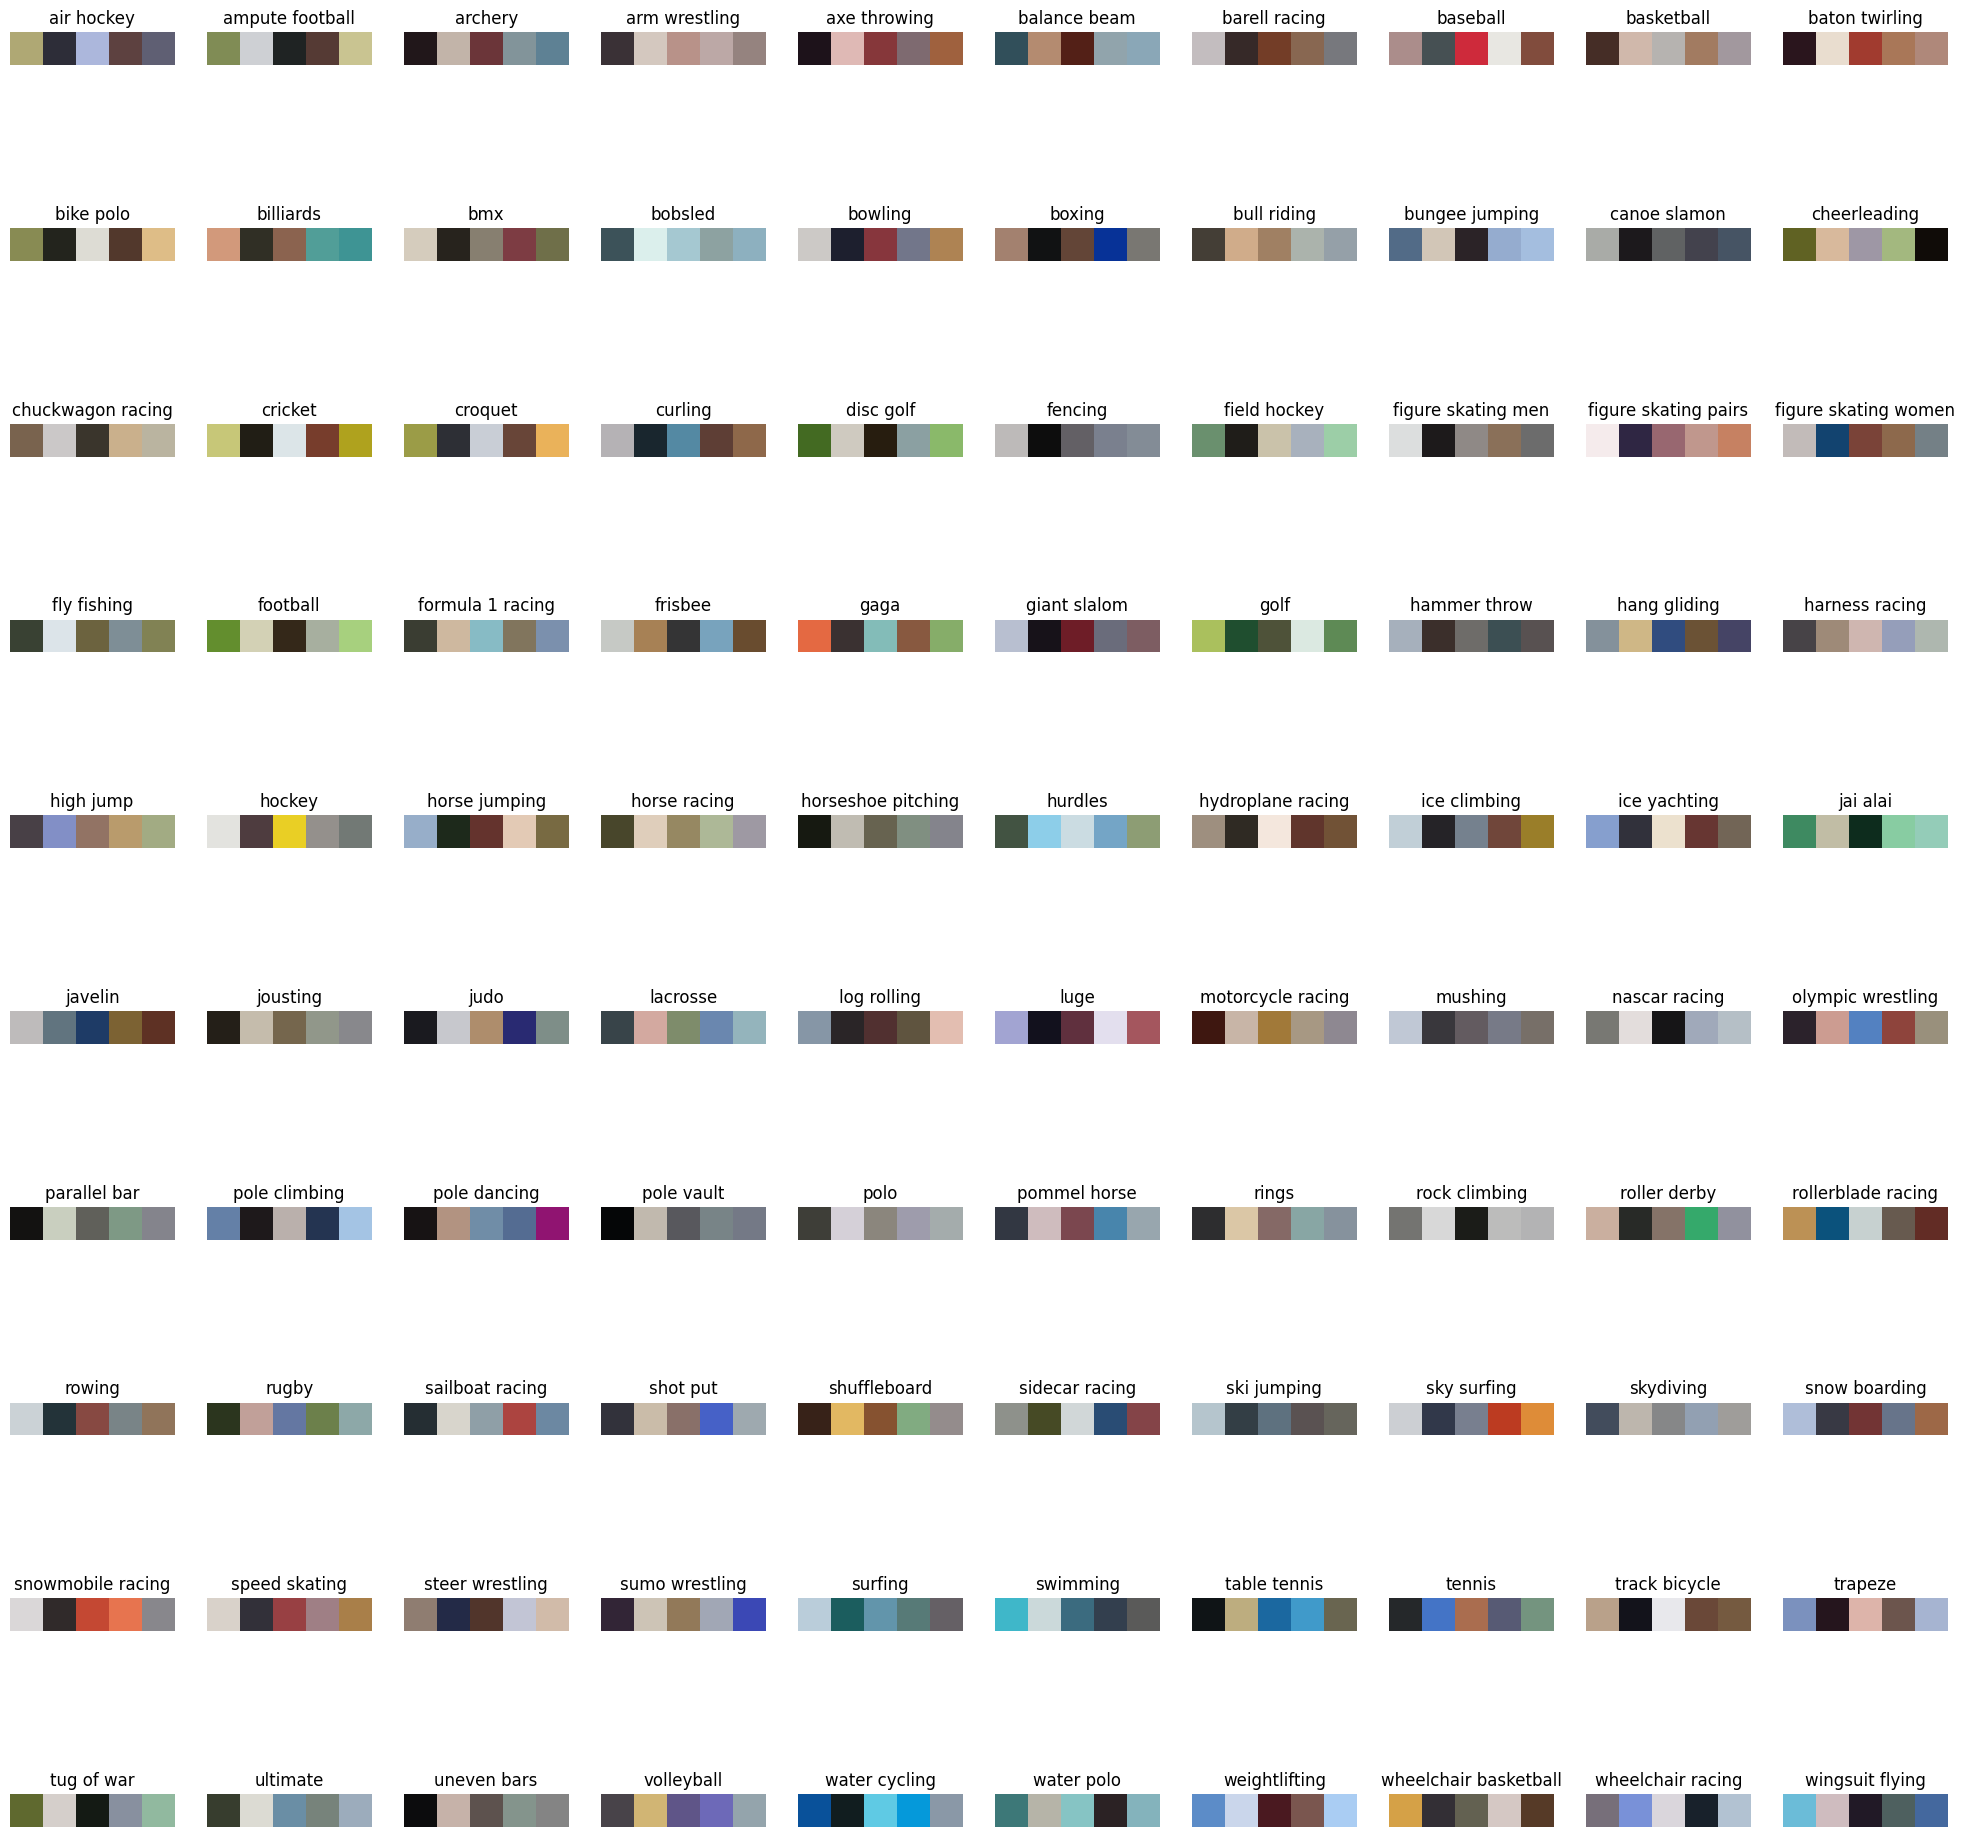

In [85]:
from colorthief import ColorThief

plt.figure(figsize = (25, 25))
for i in range(100):
    color_thief = ColorThief(imgs[i])
    palette = color_thief.get_palette(color_count = 5)
    # dominant_color = color_thief.get_color(quality = 1)
    
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow([[palette[j] for j in range(5)]])
    # plt.imshow([[dominant_color]], aspect = 'auto')
    plt.title(inv_map[i])
    plt.axis("off")

EDA 3

In [86]:
# from keras.applications.resnet import ResNet
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input, decode_predictions
from keras.utils import load_img, img_to_array

model = ResNet50(weights = 'imagenet')
predicts = []

for i in range(100):
    img_path = imgs[i]
    img = load_img(img_path, target_size = (224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    predicts.append(decode_predictions(preds, top = 3)[0])

1/1 [==============================] - 0s 381ms/step


Plot EDA 3

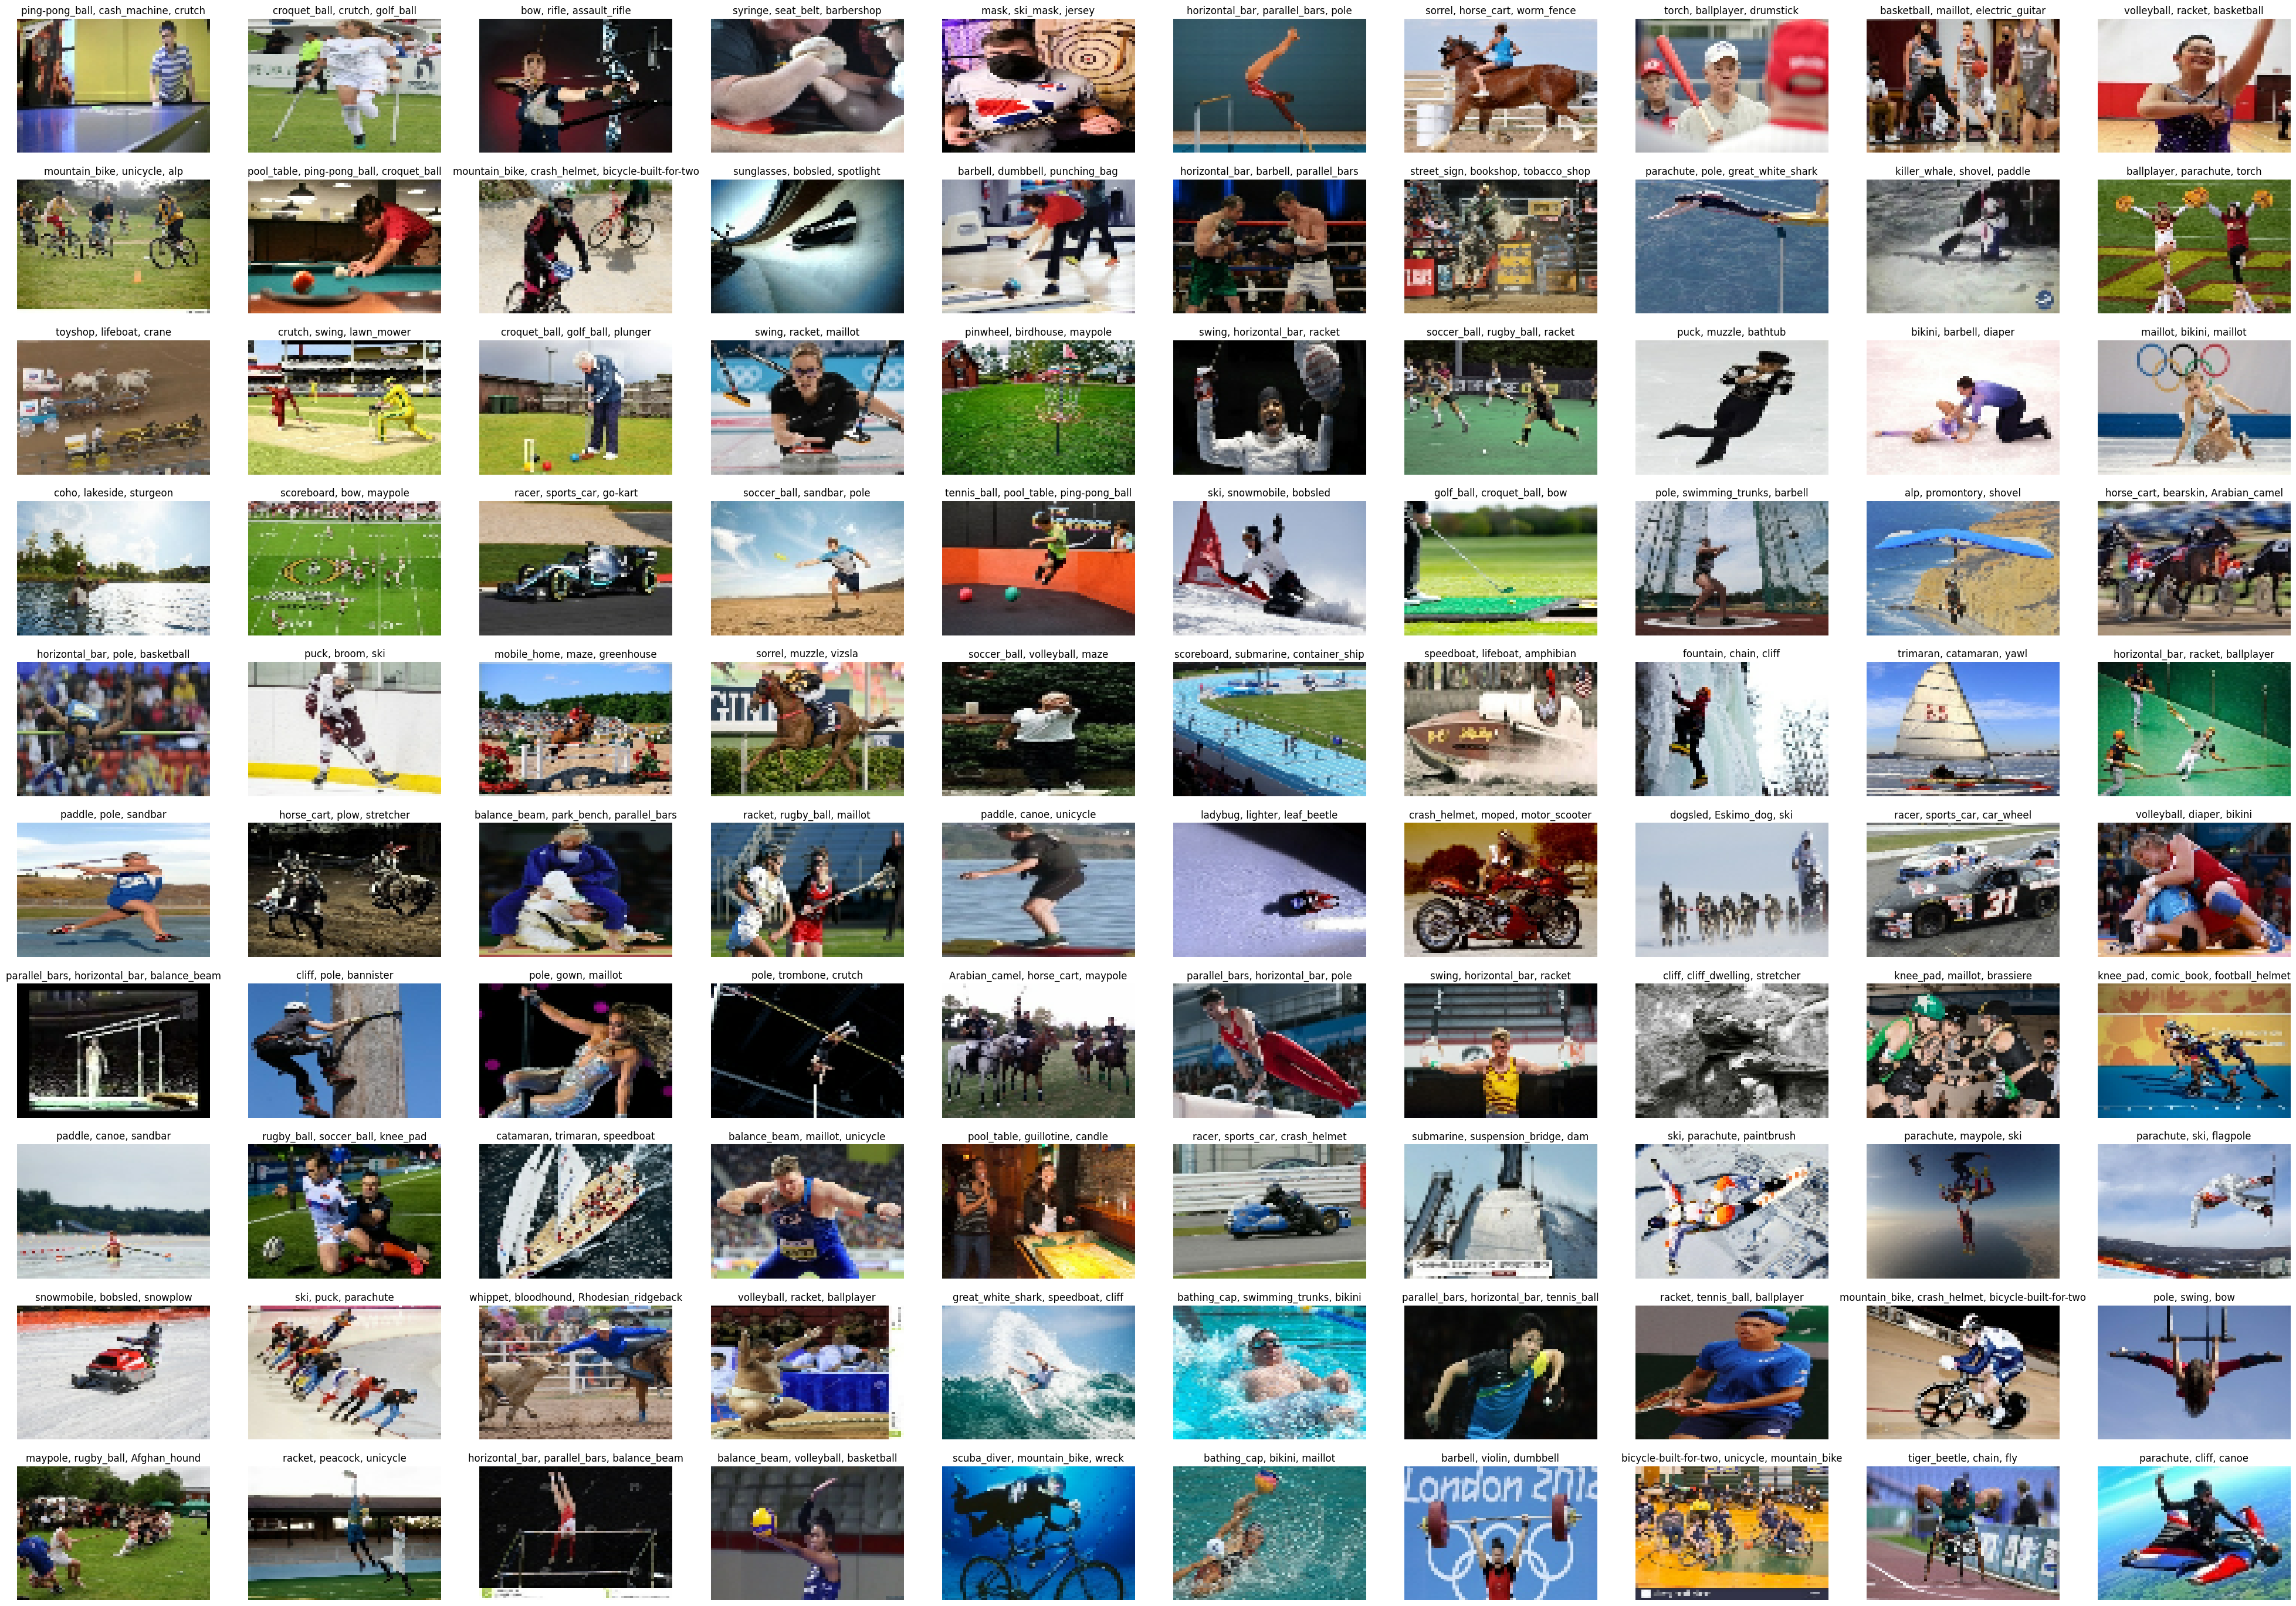

In [99]:
c = 0

plt.figure(figsize = (50, 35))
for i in range(100):
    text = []

    for j in predicts[i]:
        text.append(j[1])

    image = images[c]
    c += count[i]
    
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(image.astype("uint8"), aspect = "auto")
    plt.title(", ".join(text))
    plt.axis("off")

Model

In [196]:
model = Sequential([
    Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same', input_shape = (64, 64, 3)),
    MaxPool2D(pool_size = (2, 2), strides = 2),
    Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
    MaxPool2D(pool_size = (2, 2), strides = 2),
    Flatten(),
    Dense(units = 100, activation = 'softmax'),
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 16384)             0         
                                                                 
 dense_20 (Dense)            (None, 100)              

Compile

In [197]:
model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
callback = EarlyStopping(monitor = 'val_loss', patience = 4, restore_best_weights = False)

Train and predict

In [198]:
# history = model.fit(x = train_generator, validation_data = valid_generator, epochs = 50, verbose = 2, callbacks=[callback])

Save Model

In [199]:
from keras.models import load_model

# model.save('./models/model.h5')
model = load_model('./models/model.h5')

Predict 

In [200]:
def one_hot_label(image, label):
    label = tf.one_hot(label, 100)
    image = tf.cast(image/255. ,tf.float32)
    return image, label

autotune = tf.data.experimental.AUTOTUNE
test_generator = test_generator.map(one_hot_label, num_parallel_calls = autotune)
test_generator = test_generator.cache().prefetch(buffer_size = autotune)

predictions = model.predict(x = test_generator, verbose = 0)
loss_v, accuracy_v = model.evaluate(valid_generator, verbose = 1)
loss, accuracy = model.evaluate(test_generator, verbose = 1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

500/500 [==============================] - 10s 19ms/step - loss: 2.1541 - accuracy: 0.4560
Validation: accuracy = 0.446000  ;  loss_v = 2.215789
Test: accuracy = 0.456000  ;  loss = 2.154142


Print training

In [167]:
def plot_history(history):
    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model_accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    except:
        print('regresion model')

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

# plot_history(history)

Confusion Matrix

In [201]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=valid_generator.classes, y_pred=np.argmax(predictions, axis=1))

Plot confusion Matrix

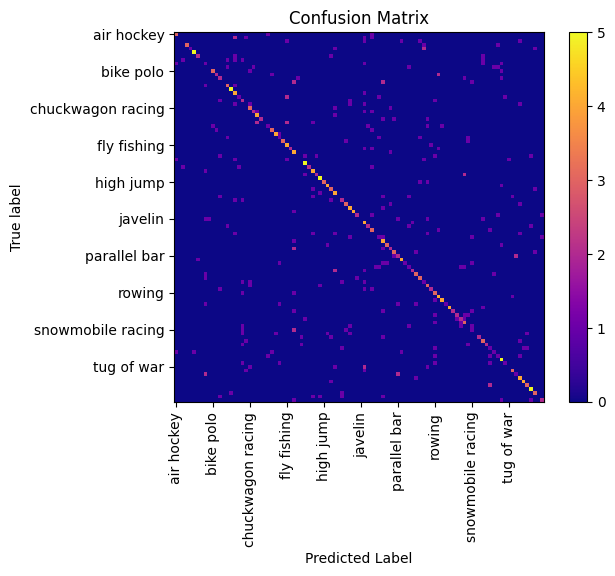

In [169]:
import itertools

def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion Matrix', cmap = plt.cm.plasma):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    plt.locator_params(axis='both', nbins = 10)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')
    plt.show()

test_labels = valid_generator.class_indices.keys()
plot_confusion_matrix(cm = cm, classes = test_labels)

In [61]:
# images = []
# rows = []
# fname = []

# model = ResNet50(weights = 'imagenet', include_top= False)

# for i in filenames:
#     for filename in os.listdir(path_train + i):
#         images.append(path_train + i + '/' + filename)
#         fname.append(filename)

# for i in range(len(images)):
#     img_path = images[i]
#     img = load_img(img_path, target_size = (224, 224))
#     x = img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = preprocess_input(x)

#     preds = model.predict(x).ravel().toList()
#     preds.insert(0, filename[i])
#     rows.append(preds)


1/1 [==============================] - 3s 3s/step


AttributeError: 'numpy.ndarray' object has no attribute 'toList'

Mobile Net

In [210]:
mobile = keras.applications.MobileNet(
    weights = 'imagenet',
    input_shape = (64, 64, 3),
    include_top = False
)

mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 32, 32, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 32, 32, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 32, 32, 32)       128       
 ation)                                         

In [218]:
from keras.models import Model

x = mobile.layers[-2].output
output = Flatten()(x)
output = Dense(units = 100, activation = 'softmax')(output)

model = Model(inputs = mobile.input, outputs = output)

for layer in model.layers[: -25]:
    layer.trainable = False

model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 32, 32, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 32, 32, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 32, 32, 32)       128       
 ation)                                                   

In [220]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# history = model.fit(x = train_generator, validation_data = valid_generator, epochs = 10, verbose = 2, callbacks=[callback])

Epoch 1/10
425/425 - 315s - loss: 3.3838 - accuracy: 0.5059 - val_loss: 2.7637 - val_accuracy: 0.5240 - 315s/epoch - 741ms/step
Epoch 2/10
425/425 - 304s - loss: 2.8912 - accuracy: 0.5703 - val_loss: 3.3600 - val_accuracy: 0.5460 - 304s/epoch - 715ms/step
Epoch 3/10
425/425 - 264s - loss: 2.7998 - accuracy: 0.5948 - val_loss: 2.8690 - val_accuracy: 0.5880 - 264s/epoch - 622ms/step
Epoch 4/10
425/425 - 278s - loss: 2.4422 - accuracy: 0.6371 - val_loss: 2.8733 - val_accuracy: 0.5880 - 278s/epoch - 655ms/step
Epoch 5/10
425/425 - 303s - loss: 2.2855 - accuracy: 0.6577 - val_loss: 2.8786 - val_accuracy: 0.6140 - 303s/epoch - 714ms/step


Load model

In [221]:
# model.save('./models/newModel2.h5')
model = load_model('./models/newModel2.h5')

In [222]:
# test_generator = test_generator.map(one_hot_label, num_parallel_calls = autotune)
# test_generator = test_generator.cache().prefetch(buffer_size = autotune)

predictions = model.predict(x = test_generator, verbose = 0)
loss_v, accuracy_v = model.evaluate(valid_generator, verbose = 1)
loss, accuracy = model.evaluate(test_generator, verbose = 1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

500/500 [==============================] - 15s 29ms/step - loss: 2.0788 - accuracy: 0.7020
Validation: accuracy = 0.634000  ;  loss_v = 2.637061
Test: accuracy = 0.702000  ;  loss = 2.078831


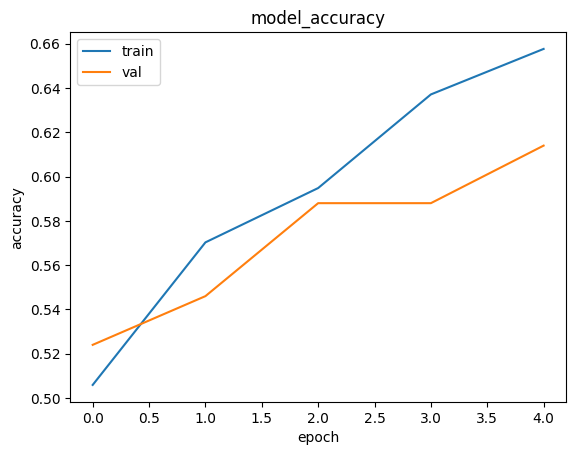

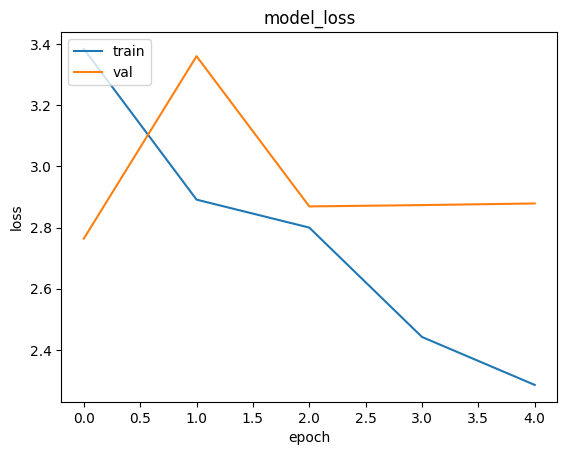

In [223]:
# plot_history(history)

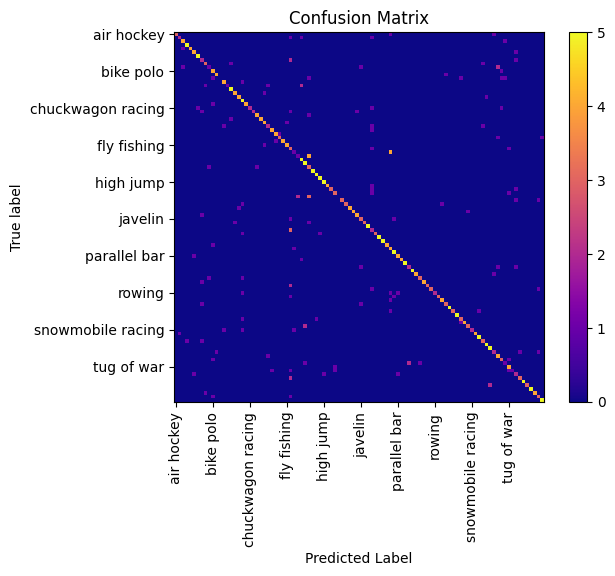

In [224]:
cm = confusion_matrix(y_true = valid_generator.classes, y_pred = np.argmax(predictions, axis = 1))
plot_confusion_matrix(cm = cm, classes = test_labels)

Custom images

In [246]:
ownTest = './data-z3/own-tests/'

test_generator_2 = tf.keras.preprocessing.image_dataset_from_directory(
  directory = ownTest,
  image_size = IMG_SIZE,
  batch_size = BATCH_SIZE,
  shuffle = False
)

def one_hot_label_2(image, label):
    label = tf.one_hot(label, 100)
    image = tf.cast(image/255. ,tf.float32)
    return image, label

test_generator_2 = test_generator_2.map(one_hot_label_2, num_parallel_calls = autotune)
test_generator_2 = test_generator_2.cache().prefetch(buffer_size = autotune)

predictions = np.array([])
labels =  np.array([])
for x, y in test_generator_2:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis = -1)])

loss, accuracy = model.evaluate(test_generator_2, verbose = 1)

cm = tf.math.confusion_matrix(labels = labels, predictions = predictions).numpy()

Found 22 files belonging to 100 classes.
1/1 [==============================] - 0s 178ms/step - loss: 4.3363 - accuracy: 0.2727


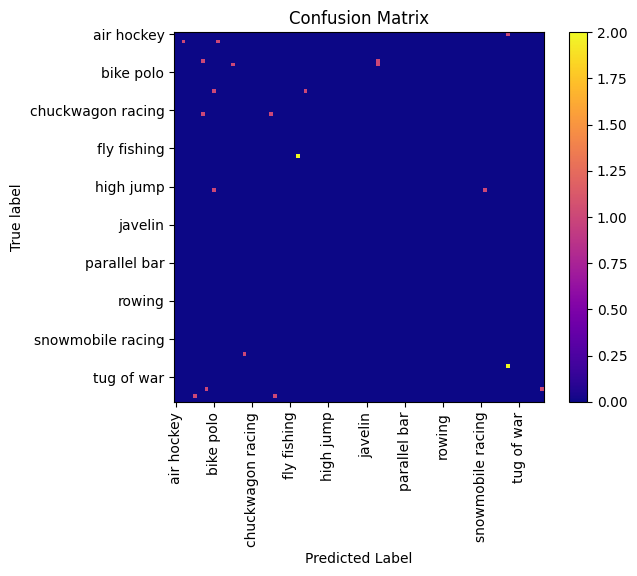

In [249]:
plot_confusion_matrix(cm = cm, classes = test_labels)